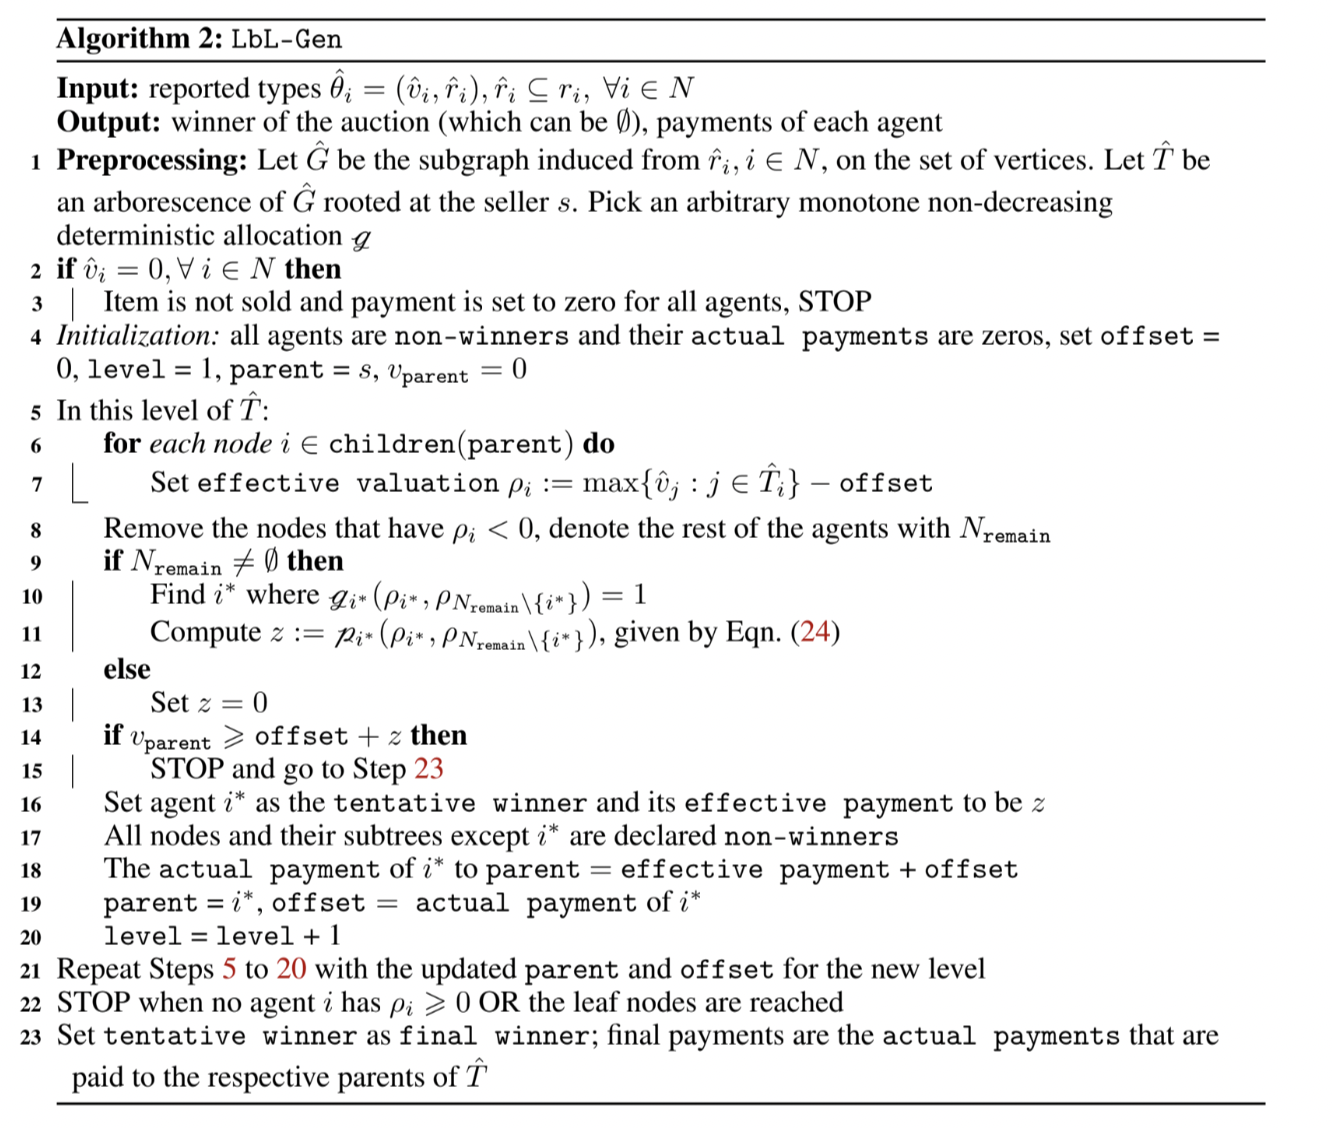

In [14]:
import matplotlib.pyplot as plt

In [15]:
class Network():
  def __init__(self, name, v):
    self.name = name
    self.v = v
    self.r = []
    self.v_hat = v
    self.r_hat = []
    self.children = []
  def set_v(self, v):
    self.v = v
  def set_v_hat(self, v_hat):
    self.v_hat = v_hat
  def set_r(self, r):
    self.r = r
  def set_r_hat(self, r_hat):
    self.r_hat = r_hat
  def add_child(self, child):
    self.children.append(child)
  def remove_child(self, child):
    for c in self.children:
      if c.name == child.name:
        self.children.remove(c)
    return
  def __deepcopy__(self, memo):
    res = Network(self.name, self.v)
    for child in self.children:
      res.children.append(copy.deepcopy(child))
    return res

In [16]:
def get_nodes(root, network_nodes, visited):
  if root.name in visited:
    return
  network_nodes[root.name] = root
  visited.append(root.name)
  for child in root.children:
    get_nodes(child, network_nodes, visited)


In [17]:
def generate_random_graph(n):
  import networkx as nx
  import random
  G=nx.gnp_random_graph(n,0.2,directed=True) # 0.5 = probability of edge creation

  DAG = nx.DiGraph([(u,v) for (v, u) in G.edges() if u<v])

  for node in DAG.nodes:
    if DAG.in_degree(node) == 0:
      sink = node
      break

  mapping = {}
  mapping[sink] = 0
  for node in DAG.nodes():
    if node != sink and node != 0:
      mapping[node] = node
    else:
      if node == 0:
        mapping[node] = sink
  DAG = nx.relabel_nodes(DAG, mapping)

  keep_nodes = []

  for node in DAG.nodes():
    if nx.has_path(DAG, 0, node):
      keep_nodes.append(node)

  DAG = nx.DiGraph([(u,v) for (u, v) in DAG.edges() if u in keep_nodes])

  nx.is_directed_acyclic_graph(DAG)
  edges = DAG.edges()
  nodes = DAG.nodes()
  network_nodes = {}
  for node in nodes:
    if node == 0:
      root = Network(0, 0) # name, v
      network_nodes[0] = root
    else:
      v = random.randint(0, 1000)
      new_node = Network(node, v)
      network_nodes[node] = new_node
  for edge in edges:
    network_nodes[edge[0]].add_child(network_nodes[edge[1]])
  return root, network_nodes

In [18]:
def traverse_tree(root, v_dict={}, v_hat_dict={}, r_dict={}, r_hat_dict={}, stack=[], depth={}): #bfs
  global sc
  v_dict[root.name] = root.v
  v_hat_dict[root.name] = root.v_hat
  r_dict[root.name] = root.r
  r_hat_dict[root.name] = root.r_hat

  for child in root.children:
    stack.append(child)
    if child.name not in list(depth.keys()):
      depth[child.name] = depth[root.name]+1

  while(sc<len(stack)):
    sc += 1
    traverse_tree(stack[sc-1], v_dict, v_hat_dict, r_dict, r_hat_dict, stack, depth)
  return

In [19]:
def mechanism(parent, a, p, offset=0):
  v_dict={}
  v_hat_dict={}
  r_dict={}
  r_hat_dict={}
  depth = {parent.name:0}
  nodes = {}
  stack=[]
  global sc
  sc=0
  traverse_tree(parent, v_dict, v_hat_dict, r_dict, r_hat_dict, stack, depth)
  if(sum(list(v_hat_dict.values()))==0):
    for key in list(v_dict.keys()):
      a[key] = 0
      p[key] = 0
    return
  if parent.name == 0:  
    mu_parent = 0
  else:
    mu_parent = v_dict[parent.name]
  N_remain = []
  rho = {}
  depths = {}
  z = None
  for child in parent.children:
    v_dict_temp={}
    v_hat_dict_temp={}
    r_dict_temp={}
    r_hat_dict_temp={}
    stack_temp=[]
    sc=0
    depth_temp={child.name:0}
    traverse_tree(child, v_dict_temp, v_hat_dict_temp, r_dict_temp, r_hat_dict_temp, stack_temp, depth_temp)
    mx_v_hat_i = child.name
    for grand_child_name in list(v_hat_dict_temp.keys()):
      if v_hat_dict_temp[grand_child_name]>v_hat_dict_temp[mx_v_hat_i]:
        mx_v_hat_i = grand_child_name
      else:
        if v_hat_dict_temp[grand_child_name]==v_hat_dict_temp[mx_v_hat_i]:
          if depth_temp[grand_child_name]<depth_temp[mx_v_hat_i]:
            mx_v_hat_i = grand_child_name
      rho[child.name] = v_hat_dict_temp[mx_v_hat_i]-offset
      depths[child.name] = depth_temp[mx_v_hat_i]
    if rho[child.name]>=0:
      N_remain.append(child)
  if len(N_remain) == 0:
    z = 0
    return
  else:
    mx = 0
    mx2 = 0
    i_star = N_remain[0]
    l = None
    for ni in range(len(N_remain)):
      pti = rho[N_remain[ni].name]
      if pti>mx:
        mx = pti
        i_star = N_remain[ni]
      else:
        if pti==mx:
          if depths[N_remain[ni].name]<depths[i_star.name]:
            mx = pti
            i_star = N_remain[ni]
    num_mx = 0
    for ni in range(len(N_remain)):
      pti = rho[N_remain[ni].name]
      if pti==mx:
        num_mx+=1
        if num_mx>1:
          mx2 = pti
          l = N_remain[ni]
          break
      else:
        if pti>mx2:
          mx2 = pti
          l = N_remain[ni]
    if l is not None:
        z = rho[l.name]
    else :
        z = 0
    
    if i_star == None:
      z = 0
  if mu_parent >= offset + z:
    return
  else:
    for key in v_dict.keys():
      a[key] = 0
    a[i_star.name] = 1
    p[i_star.name] += z + offset
    p[parent.name] += - z - offset
    parent = i_star
    offset = z + offset
    mechanism(parent, a, p, offset)

In [20]:
def utility(ai, pi, vi):
  return ai*vi-pi

def is_ir(a, p, v_dict):
  for key in list(a.keys()):
    if (utility(a[key], p[key], v_dict[key]) < 0):
      return False
  return True

In [21]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

In [22]:
def is_ic(a, p, v_dict):
  global global_root
  global global_network_nodes
  for alpha in range(-1000, -990, 10):
    for vkey in list(global_network_nodes.keys()):
      global_network_nodes[vkey].v_hat += alpha
      a_new, p_new, v_dict = to_tree_mechanism()
      new_utility = utility(a_new[vkey], p_new[vkey], v_dict[vkey])
      old_utility = utility(a[vkey], p[vkey], v_dict[vkey])
      if new_utility>old_utility:
        return False
      global_network_nodes[vkey].v_hat -= alpha
  for vkey in list(global_network_nodes.keys()):
    original_children = []
    for orig_child in global_network_nodes[vkey].children:
      original_children.append(orig_child)
    possible_children_set = powerset(global_network_nodes[vkey].children)
    for possible_children in possible_children_set:
      global_network_nodes[vkey].children = possible_children
      # a_new = {}
      # p_new = {}
      # for key in v_dict.keys():
      #   a_new[key] = 0
      #   p_new[key] = 0
      # offset = 0
      # mechanism(root, a_new, p_new, offset)
      a_new, p_new, v_dict = to_tree_mechanism()
      new_utility = utility(a_new[vkey], p_new[vkey], v_dict[vkey])
      old_utility = utility(a[vkey], p[vkey], v_dict[vkey])
      if new_utility>old_utility:
        # print('Error in DSIC at: ')
        # print('node: ', vkey)
        # print('v true: ', nodes[vkey].v)
        # print('v hat: ', nodes[vkey].v_hat)
        # print('old util: ', old_utility)
        # print('new util: ', new_utility)
        # assert 1 == 0
        return False
      global_network_nodes[vkey].children = original_children
  return True

In [23]:
import copy
def find_lca(node1, node2, parent):
    path1 = []
    path2 = []
    curr = copy.deepcopy(node1)
    
    while True:
        path1.insert(0, curr.name)
        if curr.name not in parent.keys():
            break
        curr = parent[curr.name]
        
    curr = copy.deepcopy(node2)
    while True:
        path2.insert(0, curr.name)
        if curr.name not in parent.keys():
            break
        curr = parent[curr.name]

    for i in range(max(len(path1), len(path2))):
        if len(path1) == i:
            return path1[i-1]
        if len(path2) == i:
            return path2[i-1]
        if path1[i] != path2[i]:
            return path1[i-1]

def convert_to_tree():
    global global_network_nodes
    global global_root
    global tree_root
    global tree_network_nodes
    tree_root = copy.deepcopy(global_root)
    tree_network_nodes = {}
    nodes_visited = []
    get_nodes(tree_root, tree_network_nodes, nodes_visited)
    visited = {}
    parent = {}
    for node in tree_network_nodes.values():
        visited[node.name] = False
    visited[tree_root.name] = True
    q = []
    q.append(tree_root)
    
    while len(q) != 0:
        curr = q.pop(0)
        for child in curr.children:
            # print("child:", child.name)
            # print("parent:", parent[child.name])
            # print("curr:", curr.name)
            if not visited[child.name]:
                # print("c1")
                parent[child.name] = curr
                visited[child.name] = True
            elif parent[child.name].name != curr.name :
                # print("c2")
                # print("Parent 1:", curr.name)
                # print("Parent 2:", parent[child.name].name)
                lca = tree_network_nodes[find_lca(curr, parent[child.name], parent)]
                # print("LCA :", lca.name)
                # print("Children Before")
                # for c in curr.children:
                #     print(c.name)

                curr.remove_child(child)
                # print("Children After")
                # for c in curr.children:
                #     print(c.name)
                parent[child.name].remove_child(child)
                parent[child.name] = lca
                lca.children.append(child)
                q.append(lca)

            q.append(child)

import networkx as nx
def fill_edges(node, edges, visited):
    for c in node.children:
        edges.append((node.name, c.name))
        if c.name not in visited:
            visited.append(c.name)
            fill_edges(c, edges, visited)

def show(root):
    edges = []
    visited = []
    visited.append(root.name)
    fill_edges(root, edges, visited)
    # print(edges)
    G = nx.DiGraph([(u, v) for (u,v) in edges])
    nx.draw(G, with_labels=True, pos=nx.circular_layout(G))

In [24]:
def to_tree_mechanism():

  convert_to_tree()
  global tree_root
  global sc
  v_dict={}
  v_hat_dict={}
  r_dict={}
  r_hat_dict={}
  stack=[]
  depth={0:0}
  sc = 0
  # print("v_dict before:", v_dict)
  # show(tree_root)
  traverse_tree(tree_root, v_dict, v_hat_dict, r_dict, r_hat_dict, stack, depth)
  a = {}
  p = {}
  # print("v_dict after")
  # print(v_dict)
  for key in v_dict.keys():
      a[key] = 0
      p[key] = 0
  offset = 0
  mechanism(tree_root, a, p, offset)
  return a, p, v_dict

In [26]:
from itertools import product

global global_network_nodes
global global_root
global tree_root
global tree_network_nodes

num_nodes = 4 # without seller
epsilon = 0.1 # values of v will be generated from 0 to 1 with separation = epsilon
check_ic_ir = False # checking ic, ir at every step will take very long
end = int(100//(epsilon*100)+1)
v_dist = [i*epsilon for i in range(0, end, 1)]
r_dist = [powerset([]), powerset([]), powerset([]), powerset([3,4])] # change this to set neighbours of each node, length should be the same as n
total_p = 0
num_instances = 0
file = open('exp_rev_out', 'w')

all_vs = [v_dist for _ in range(num_nodes)]
v_dist = list(product(*all_vs))
r_dist = list(product(*r_dist))
file.write(str(r_dist))                                     
for v in v_dist:
  for r in r_dist:
    global_root = Network(0, 0)
    global_network_nodes = {0: global_root}
    for i in range(num_nodes):
      global_network_nodes[i+1] = Network(i+1, v[i])
    for i in range(num_nodes):
      for child in r[i]:
        global_network_nodes[i+1].children.append(global_network_nodes[child])
    global_network_nodes[0].children = [global_network_nodes[1], global_network_nodes[2]]
    tree_root = None
    tree_network_nodes = None
    a, p, v_dict = to_tree_mechanism()
    if check_ic_ir :
        bool_ic = is_ic(a, p, v_dict)
        bool_ir = is_ir(a, p, v_dict)
        assert bool_ic
        assert bool_ir
    file.write('Payment 0: ')
    file.write(str(p[0]))
    total_p+=p[0]
    num_instances+=1
    file.write('Expected Revenue till now: ')
    expected_revenue = total_p/num_instances
    print(expected_revenue)
    file.write(str(expected_revenue))
print('Expected Revenue: ')
expected_revenue = total_p/num_instances
print(expected_revenue)
file.close()

Streaming output truncated to the last 5000 lines.
-0.2981686486083276
-0.2981630824373186
-0.29815751647412275
-0.29815195071872846
-0.29814638517112396
-0.29814081983129775
-0.29813525469923813
-0.2981296897749334
-0.29812412505837205
-0.2981185605495424
-0.2981129962484328
-0.2981074321550316
-0.2981018682693272
-0.298096304591308
-0.29809074112096234
-0.2980851778582786
-0.29807961480324513
-0.2980740519558503
-0.29806848931608254
-0.29806292688393016
-0.2980573646593816
-0.2980518026424252
-0.29804624083304937
-0.29804067923124244
-0.2980351178369928
-0.2980295566502889
-0.29802399567111904
-0.29801843489947166
-0.2980128743353351
-0.29800731397869773
-0.29800175382954797
-0.29799619388787424
-0.29799063415366484
-0.29798507462690826
-0.2979795153075928
-0.29797395619570693
-0.297968397291239
-0.2979628385941773
-0.29795728010451045
-0.2979517218222267
-0.2979461637473144
-0.297940605879762
-0.29793504821955796
-0.2979294907666906
-0.2979239335211483
-0.2979183764829195
-0.2979128